## 1.Import Libraries

In [13]:
!pip install feature_engine

Defaulting to user installation because normal site-packages is not writeable


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    MinMaxScaler,
    PowerTransformer,
    FunctionTransformer,
    StandardScaler,
    OrdinalEncoder
)
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import (
    RareLabelEncoder,
    MeanEncoder,
    CountFrequencyEncoder
)
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
import warnings

## 2.Display Settings

In [2]:
pd.set_option("display.max_columns",None)

In [3]:
sklearn.set_config(transform_output="pandas")

In [4]:
warnings.filterwarnings("ignore")

## 3.Read the Data

In [5]:
path=r"D:\flight_price_sagemaker_project\Data\train.csv"
train=pd.read_csv(path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-03-09,Delhi,Cochin,19:45:00,18:50:00,1385,1.0,No Info,16289
1,Air India,2019-03-06,Mumbai,Hyderabad,17:20:00,14:50:00,150,2.0,No Info,11972
2,Indigo,2019-06-09,Delhi,Cochin,11:25:00,21:00:00,575,1.0,No Info,6416
3,Indigo,2019-05-01,Banglore,Delhi,23:30:00,02:20:00,170,0.0,No Info,4591
4,Jet Airways,2019-06-03,Delhi,Cochin,17:30:00,04:25:00,655,1.0,No Info,14714
...,...,...,...,...,...,...,...,...,...,...
635,Indigo,2019-06-01,Delhi,Cochin,14:25:00,17:40:00,195,0.0,No Info,6015
636,Vistara,2019-05-01,Banglore,Delhi,11:30:00,14:20:00,170,0.0,No Info,4668
637,Spicejet,2019-05-18,Chennai,Kolkata,08:20:00,10:35:00,135,0.0,No check-in baggage included,3543
638,Indigo,2019-06-15,Banglore,Delhi,13:00:00,15:50:00,170,0.0,No Info,3943


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [7]:
X_train=train.drop(columns="price")
y_train=train.price.copy()

## 4.Transformation Operations

### 4.1 airline

In [8]:
X_train.airline

0      Jet Airways
1        Air India
2           Indigo
3           Indigo
4      Jet Airways
          ...     
635         Indigo
636        Vistara
637       Spicejet
638         Indigo
639    Jet Airways
Name: airline, Length: 640, dtype: object

In [9]:
air_transformer=Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("grouper",RareLabelEncoder(tol=0.1,replace_with="Other",n_categories=2)),
    ("encoder",OneHotEncoder(sparse_output=False,handle_unknown="ignore"))
])
air_transformer.fit_transform(X_train.loc[:,["airline"]])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
635,0.0,1.0,0.0,0.0,0.0
636,0.0,0.0,0.0,0.0,1.0
637,0.0,0.0,0.0,0.0,1.0
638,0.0,1.0,0.0,0.0,0.0


### 4.2 date_of_journey

In [12]:
X_train.date_of_journey

0      2019-03-09
1      2019-03-06
2      2019-06-09
3      2019-05-01
4      2019-06-03
          ...    
635    2019-06-01
636    2019-05-01
637    2019-05-18
638    2019-06-15
639    2019-06-18
Name: date_of_journey, Length: 640, dtype: object

In [19]:
feature_to_extract=["month","week","day_of_week","day_of_year"]
doj_transformer=Pipeline(steps=[
    ("dt",DatetimeFeatures(features_to_extract=feature_to_extract,yearfirst=True,format="mixed")),
    ("scaler",MinMaxScaler())
])
doj_transformer.fit_transform(X_train.loc[:,["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.000000,0.058824,0.833333,0.067797
1,0.000000,0.058824,0.333333,0.042373
2,1.000000,0.823529,1.000000,0.847458
3,0.666667,0.529412,0.333333,0.516949
4,1.000000,0.823529,0.000000,0.796610
...,...,...,...,...
635,1.000000,0.764706,0.833333,0.779661
636,0.666667,0.529412,0.333333,0.516949
637,0.666667,0.647059,0.833333,0.661017
638,1.000000,0.882353,0.833333,0.898305


### 4.3 source & destination

In [21]:
X_train.source

0         Delhi
1        Mumbai
2         Delhi
3      Banglore
4         Delhi
         ...   
635       Delhi
636    Banglore
637     Chennai
638    Banglore
639      Mumbai
Name: source, Length: 640, dtype: object

In [22]:
X_train.destination

0         Cochin
1      Hyderabad
2         Cochin
3          Delhi
4         Cochin
         ...    
635       Cochin
636        Delhi
637      Kolkata
638        Delhi
639    Hyderabad
Name: destination, Length: 640, dtype: object

In [24]:
location_subset=X_train.loc[:,["source","destination"]]
location_subset

,source,destination
0,Delhi,Cochin
1,Mumbai,Hyderabad
2,Delhi,Cochin
3,Banglore,Delhi
4,Delhi,Cochin
...,...,...
635,Delhi,Cochin
636,Banglore,Delhi
637,Chennai,Kolkata
638,Banglore,Delhi


In [32]:
location_pipe1=Pipeline(steps=[
    ("grouper",RareLabelEncoder(tol=0.1,replace_with="Other",n_categories=2)),
    ("encoder",MeanEncoder()),
    ("scaler",PowerTransformer())
])
location_pipe1.fit_transform(location_subset,y_train)

,source,destination
0,1.035261,1.018547
1,-1.879634,-0.536667
2,1.035261,1.018547
3,-0.831514,-1.870129
4,1.035261,1.018547
...,...,...
635,1.035261,1.018547
636,-0.831514,-1.870129
637,-1.879634,-0.536667
638,-0.831514,-1.870129


In [33]:
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [39]:
def is_north(X):
    columns=X.columns.to_list()
    north_cities=["Delhi","Kolkata","Mumbai","New Delhi"]
    return (
        X
        .assign(**{
            f"{col}_is_north":X.loc[:,col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
    )
FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,1,0
3,0,1
4,1,0
...,...,...
635,1,0
636,0,1
637,0,1
638,0,1


In [42]:
location_transformer=FeatureUnion(transformer_list=[
    ("part1",location_pipe1),
    ("part2",FunctionTransformer(func=is_north))
])
location_transformer.fit_transform(location_subset,y_train)

,source,destination,source_is_north,destination_is_north
0,1.035261,1.018547,1,0
1,-1.879634,-0.536667,1,0
2,1.035261,1.018547,1,0
3,-0.831514,-1.870129,0,1
4,1.035261,1.018547,1,0
...,...,...,...,...
635,1.035261,1.018547,1,0
636,-0.831514,-1.870129,0,1
637,-1.879634,-0.536667,0,1
638,-0.831514,-1.870129,0,1


### 4.4 dep_time & arrival_time

In [46]:
X_train.dep_time

0      19:45:00
1      17:20:00
2      11:25:00
3      23:30:00
4      17:30:00
         ...   
635    14:25:00
636    11:30:00
637    08:20:00
638    13:00:00
639    02:55:00
Name: dep_time, Length: 640, dtype: object

In [47]:
X_train.arrival_time

0      18:50:00
1      14:50:00
2      21:00:00
3      02:20:00
4      04:25:00
         ...   
635    17:40:00
636    14:20:00
637    10:35:00
638    15:50:00
639    04:20:00
Name: arrival_time, Length: 640, dtype: object

In [49]:
time_subset=X_train.loc[:,["dep_time","arrival_time"]]
time_subset

,dep_time,arrival_time
0,19:45:00,18:50:00
1,17:20:00,14:50:00
2,11:25:00,21:00:00
3,23:30:00,02:20:00
4,17:30:00,04:25:00
...,...,...
635,14:25:00,17:40:00
636,11:30:00,14:20:00
637,08:20:00,10:35:00
638,13:00:00,15:50:00


In [52]:
time_pipe1=Pipeline(steps=[
    ("dt",DatetimeFeatures(features_to_extract=["hour","minute"])),
    ("scaler",MinMaxScaler())
])
time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.826087,0.818182,0.782609,0.909091
1,0.739130,0.363636,0.608696,0.909091
2,0.478261,0.454545,0.913043,0.000000
3,1.000000,0.545455,0.086957,0.363636
4,0.739130,0.545455,0.173913,0.454545
...,...,...,...,...
635,0.608696,0.454545,0.739130,0.727273
636,0.478261,0.545455,0.608696,0.363636
637,0.347826,0.363636,0.434783,0.636364
638,0.565217,0.000000,0.652174,0.909091


In [54]:
def part_of_day(X,morning=4,noon=12,eve=16,night=20):
    columns=X.columns.to_list()
    X_temp=X.assign(**{
        col:pd.to_datetime(X.loc[:,col]).dt.hour
        for col in columns
    })
    return (
        X_temp
        .assign(**{
            f"{col}_part_of_day":np.select(
                [X_temp.loc[:,col].between(morning,noon,inclusive="left"),
                 X_temp.loc[:,col].between(noon,eve,inclusive="left"),
                 X_temp.loc[:,col].between(eve,night,inclusive="left")
                ],
                ["morning","afternoon","evening"],
                default="night"
            )
            for col in columns
        })
        .drop(columns=columns)
    )

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,evening,evening
1,evening,afternoon
2,morning,night
3,night,night
4,evening,morning
...,...,...
635,afternoon,evening
636,morning,afternoon
637,morning,morning
638,afternoon,afternoon


In [57]:
time_pipe2=Pipeline(steps=[
    ("part",FunctionTransformer(func=part_of_day)),
    ("encoder",CountFrequencyEncoder()),
    ("scaler",MinMaxScaler())
])
time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,0.301435,0.634615
1,0.301435,0.000000
2,1.000000,1.000000
3,0.306220,1.000000
4,0.301435,0.942308
...,...,...
635,0.000000,0.634615
636,1.000000,0.000000
637,1.000000,0.942308
638,0.000000,0.000000


In [59]:
time_transformer=FeatureUnion(transformer_list=[
    ("part1",time_pipe1),
    ("part2",time_pipe2)
])
time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.826087,0.818182,0.782609,0.909091,0.301435,0.634615
1,0.739130,0.363636,0.608696,0.909091,0.301435,0.000000
2,0.478261,0.454545,0.913043,0.000000,1.000000,1.000000
3,1.000000,0.545455,0.086957,0.363636,0.306220,1.000000
4,0.739130,0.545455,0.173913,0.454545,0.301435,0.942308
...,...,...,...,...,...,...
635,0.608696,0.454545,0.739130,0.727273,0.000000,0.634615
636,0.478261,0.545455,0.608696,0.363636,1.000000,0.000000
637,0.347826,0.363636,0.434783,0.636364,1.000000,0.942308
638,0.565217,0.000000,0.652174,0.909091,0.000000,0.000000


### 4.5 duration

In [61]:
X_train.duration

0      1385
1       150
2       575
3       170
4       655
       ... 
635     195
636     170
637     135
638     170
639      85
Name: duration, Length: 640, dtype: int64

In [71]:
(
    X_train
    .duration
    .quantile([0.25,0.5,0.75])
    .values
    .reshape(-1,1)
)

array([[170.  ],
       [450.  ],
       [848.75]])

In [74]:
class RBFPercentileSimilarity(BaseEstimator,TransformerMixin):
    def __init__(self,variables=None,percentiles=[0.25,0.5,0.75],gamma=0.1):
        self.variables=variables
        self.percentiles=percentiles
        self.gamma=gamma
    def fit(self,X,y=None):
        if not self.variables:
            self.variables=X.select_dtypes(include="number").columns.to_list()
        self.reference_values_={
            col:(
                X
                .loc[:,col]
                .quantile(self.percentiles)
                .values
                .reshape(-1,1)
            )
            for col in self.variables
        }
        return self
    def transform(self,X):
        objects=[]
        for col in self.variables:
            columns=[f"{col}_rbf_{int(percentile*100)}" for percentile in self.percentiles]
            obj=pd.DataFrame(
                data=rbf_kernel(X.loc[:,[col]],Y=self.reference_values_[col],gamma=self.gamma),
                columns=columns
            )
            objects.append(obj)
        return pd.concat(objects,axis=1)

In [76]:
RBFPercentileSimilarity(percentiles=[0.4,0.8]).fit_transform(X_train)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,0.0,0.0,1.000000,1.000000
1,0.0,0.0,0.904837,0.904837
2,0.0,0.0,1.000000,1.000000
3,0.0,0.0,0.904837,0.904837
4,0.0,0.0,1.000000,1.000000
...,...,...,...,...
635,0.0,0.0,0.904837,0.904837
636,0.0,0.0,0.904837,0.904837
637,0.0,0.0,0.904837,0.904837
638,0.0,0.0,0.904837,0.904837


In [104]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [105]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

In [106]:
duration_pipe1=Pipeline(steps=[
    ("rbf",RBFPercentileSimilarity()),
    ("scaler",PowerTransformer())
])
duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union=FeatureUnion(transformer_list=[
    ("part1",duration_pipe1),
    ("part2",duration_pipe2),
    ("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])
duration_transformer=Pipeline(steps=[
    ("outliers",Winsorizer(capping_method="iqr",fold=1.5)),
    ("imputer",SimpleImputer(strategy="median")),
    ("union",duration_union)
])
duration_transformer.fit_transform(X_train.loc[:,["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.371363,-0.144083,-0.086226,2.0,1,1.633814
1,-0.371363,-0.144083,-0.086226,0.0,0,-0.926116
2,-0.371363,-0.144083,-0.086226,2.0,0,-0.045169
3,3.068396,-0.144083,-0.086226,0.0,0,-0.884660
4,-0.371363,-0.144083,-0.086226,2.0,0,0.120657
...,...,...,...,...,...,...
635,-0.371363,-0.144083,-0.086226,1.0,0,-0.832840
636,3.068396,-0.144083,-0.086226,0.0,0,-0.884660
637,-0.371363,-0.144083,-0.086226,0.0,0,-0.957209
638,3.068396,-0.144083,-0.086226,0.0,0,-0.884660


### 4.6 total_stops

In [83]:
X_train.total_stops

0      1.0
1      2.0
2      1.0
3      0.0
4      1.0
      ... 
635    0.0
636    0.0
637    0.0
638    0.0
639    0.0
Name: total_stops, Length: 640, dtype: float64

In [85]:
def is_direct(X):
    return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))
total_stops_transformer=Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("",FunctionTransformer(func=is_direct))
])
total_stops_transformer.fit_transform(X_train.loc[:,["total_stops"]])

,total_stops,is_direct_flight
0,1.0,0
1,2.0,0
2,1.0,0
3,0.0,1
4,1.0,0
...,...,...
635,0.0,1
636,0.0,1
637,0.0,1
638,0.0,1


### 4.7 additional_info

In [86]:
X_train.additional_info

0                           No Info
1                           No Info
2                           No Info
3                           No Info
4                           No Info
                   ...             
635                         No Info
636                         No Info
637    No check-in baggage included
638                         No Info
639     In-flight meal not included
Name: additional_info, Length: 640, dtype: object

In [87]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
635,0.0,1.0,0.0
636,0.0,1.0,0.0
637,0.0,0.0,1.0
638,0.0,1.0,0.0


In [88]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [89]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [90]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
635,0.0,1.0,0.0,0
636,0.0,1.0,0.0,0
637,0.0,0.0,1.0,1
638,0.0,1.0,0.0,0


## 5.Column Transformer

In [107]:
column_transformer=ColumnTransformer(transformers=[
    ("air",air_transformer,["airline"]),
    ("doj",doj_transformer,["date_of_journey"]),
    ("location",location_transformer,["source","destination"]),
    ("time",time_transformer,["dep_time","arrival_time"]),
    ("dur",duration_transformer,["duration"]),
    ("stops",total_stops_transformer,["total_stops"]),
    ("info",info_transformer,["additional_info"])
],remainder="passthrough")
column_transformer.fit_transform(X_train,y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,0.0,1.0,0.0,0.0,0.000000,0.058824,0.833333,0.067797,1.035261,1.018547,1,0,0.826087,0.818182,0.782609,0.909091,0.301435,0.634615,-0.371363,-0.144083,-0.086226,2.0,1,1.633814,1.0,0,0.0,1.0,0.0,0
1,1.0,0.0,0.0,0.0,0.0,0.000000,0.058824,0.333333,0.042373,-1.879634,-0.536667,1,0,0.739130,0.363636,0.608696,0.909091,0.301435,0.000000,-0.371363,-0.144083,-0.086226,0.0,0,-0.926116,2.0,0,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0.0,0.0,1.000000,0.823529,1.000000,0.847458,1.035261,1.018547,1,0,0.478261,0.454545,0.913043,0.000000,1.000000,1.000000,-0.371363,-0.144083,-0.086226,2.0,0,-0.045169,1.0,0,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0.0,0.0,0.666667,0.529412,0.333333,0.516949,-0.831514,-1.870129,0,1,1.000000,0.545455,0.086957,0.363636,0.306220,1.000000,3.068396,-0.144083,-0.086226,0.0,0,-0.884660,0.0,1,0.0,1.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,1.000000,0.823529,0.000000,0.796610,1.035261,1.018547,1,0,0.739130,0.545455,0.173913,0.454545,0.301435,0.942308,-0.371363,-0.144083,-0.086226,2.0,0,0.120657,1.0,0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,1.0,0.0,0.0,0.0,1.000000,0.764706,0.833333,0.779661,1.035261,1.018547,1,0,0.608696,0.454545,0.739130,0.727273,0.000000,0.634615,-0.371363,-0.144083,-0.086226,1.0,0,-0.832840,0.0,1,0.0,1.0,0.0,0
636,0.0,0.0,0.0,0.0,1.0,0.666667,0.529412,0.333333,0.516949,-0.831514,-1.870129,0,1,0.478261,0.545455,0.608696,0.363636,1.000000,0.000000,3.068396,-0.144083,-0.086226,0.0,0,-0.884660,0.0,1,0.0,1.0,0.0,0
637,0.0,0.0,0.0,0.0,1.0,0.666667,0.647059,0.833333,0.661017,-1.879634,-0.536667,0,1,0.347826,0.363636,0.434783,0.636364,1.000000,0.942308,-0.371363,-0.144083,-0.086226,0.0,0,-0.957209,0.0,1,0.0,0.0,1.0,1
638,0.0,1.0,0.0,0.0,0.0,1.000000,0.882353,0.833333,0.898305,-0.831514,-1.870129,0,1,0.565217,0.000000,0.652174,0.909091,0.000000,0.000000,3.068396,-0.144083,-0.086226,0.0,0,-0.884660,0.0,1,0.0,1.0,0.0,0


## 5.Feature Selection

In [108]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

## 6.Putting it all Together

In [109]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Jet Airways,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_year,dur__duration_cat,dur__duration,stops__total_stops,stops__is_direct_flight
0,1.0,0.000000,0.058824,0.067797,2.0,1.633814,1.0,0
1,0.0,0.000000,0.058824,0.042373,0.0,-0.926116,2.0,0
2,0.0,1.000000,0.823529,0.847458,2.0,-0.045169,1.0,0
3,0.0,0.666667,0.529412,0.516949,0.0,-0.884660,0.0,1
4,1.0,1.000000,0.823529,0.796610,2.0,0.120657,1.0,0
...,...,...,...,...,...,...,...,...
635,0.0,1.000000,0.764706,0.779661,1.0,-0.832840,0.0,1
636,0.0,0.666667,0.529412,0.516949,0.0,-0.884660,0.0,1
637,0.0,0.666667,0.647059,0.661017,0.0,-0.957209,0.0,1
638,0.0,1.000000,0.882353,0.898305,0.0,-0.884660,0.0,1


## 7.Visualizations

In [112]:
preprocessor.named_steps.keys()

dict_keys(['ct', 'selector'])

In [114]:
preprocessor.named_steps["selector"].feature_performance_

{'air__airline_Air India': np.float64(-0.008715959013289698),
 'air__airline_Indigo': np.float64(0.09638831740277516),
 'air__airline_Jet Airways': np.float64(0.14118987643654743),
 'air__airline_Multiple Carriers': np.float64(-0.0009444583906330998),
 'air__airline_Other': np.float64(0.07183383848684877),
 'doj__date_of_journey_month': np.float64(0.10056826168069732),
 'doj__date_of_journey_week': np.float64(0.14406175929815832),
 'doj__date_of_journey_day_of_week': np.float64(-0.03627220763481379),
 'doj__date_of_journey_day_of_year': np.float64(0.1789297675708822),
 'location__source': np.float64(0.07711115415396701),
 'location__destination': np.float64(0.0769037122193134),
 'location__source_is_north': np.float64(0.00544343721143048),
 'location__destination_is_north': np.float64(0.00544343721143048),
 'time__dep_time_hour': np.float64(-0.005723507625419844),
 'time__dep_time_minute': np.float64(-0.022123333190191108),
 'time__arrival_time_hour': np.float64(-0.000104351843865369),

In [99]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': np.float64(-0.008715959013289698),
 'air__airline_Indigo': np.float64(0.09638831740277516),
 'air__airline_Jet Airways': np.float64(0.14118987643654743),
 'air__airline_Multiple Carriers': np.float64(-0.0009444583906330998),
 'air__airline_Other': np.float64(0.07183383848684877),
 'doj__date_of_journey_month': np.float64(0.10056826168069732),
 'doj__date_of_journey_week': np.float64(0.14406175929815832),
 'doj__date_of_journey_day_of_week': np.float64(-0.03627220763481379),
 'doj__date_of_journey_day_of_year': np.float64(0.1789297675708822),
 'location__source': np.float64(0.07711115415396701),
 'location__destination': np.float64(0.0769037122193134),
 'location__source_is_north': np.float64(0.00544343721143048),
 'location__destination_is_north': np.float64(0.00544343721143048),
 'time__dep_time_hour': np.float64(-0.005723507625419844),
 'time__dep_time_minute': np.float64(-0.022123333190191108),
 'time__arrival_time_hour': np.float64(-0.000104351843865369),

In [100]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'doj__date_of_journey_day_of_week': np.float64(-0.03627220763481379),
 'time__dep_time_minute': np.float64(-0.022123333190191108),
 'time__dep_time_part_of_day': np.float64(-0.018838741941965814),
 'dur__duration_rbf_50': np.float64(-0.01660006438736672),
 'info__additional_info_In-flight meal not included': np.float64(-0.008733292045127738),
 'air__airline_Air India': np.float64(-0.008715959013289698),
 'info__additional_info_No Info': np.float64(-0.008293716520169081),
 'info__additional_info': np.float64(-0.008293716520169081),
 'time__arrival_time_minute': np.float64(-0.006638677419139631),
 'time__dep_time_hour': np.float64(-0.005723507625419844),
 'dur__duration_rbf_75': np.float64(-0.004554315770721666),
 'time__arrival_time_part_of_day': np.float64(-0.0018537082483857474),
 'air__airline_Multiple Carriers': np.float64(-0.0009444583906330998),
 'time__arrival_time_hour': np.float64(-0.000104351843865369),
 'location__source_is_north': np.float64(0.00544343721143048),
 'location

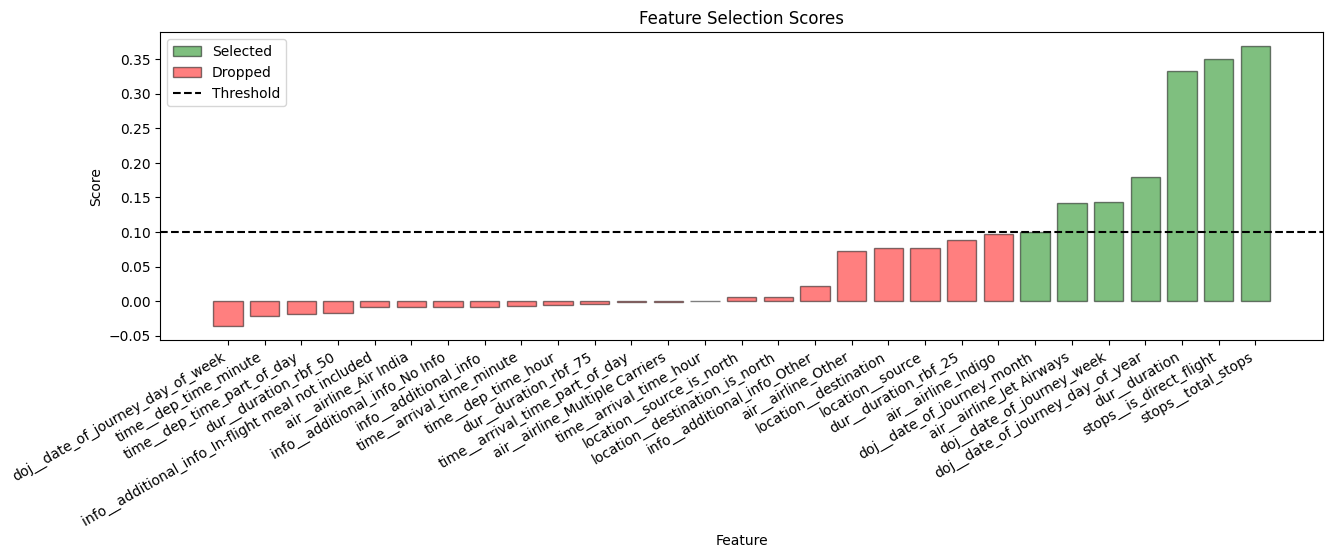

In [103]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()

In [10]:
X_train.columns.to_list()

['airline',
 'date_of_journey',
 'source',
 'destination',
 'dep_time',
 'arrival_time',
 'duration',
 'total_stops',
 'additional_info']